# COVID-19 Open Research Dataset (CORD-19) Topic Modeling

### Table of contents

## Introduction

In [1]:
!pip -q install textacy

     |████████████████████████████████| 184kB 10.4MB/s 
     |████████████████████████████████| 1.9MB 25.4MB/s 
     |████████████████████████████████| 481kB 56.2MB/s 
     |████████████████████████████████| 92kB 5.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/CORD-19-research-challenge.zip -d ~/CORD-19-research-challenge/

In [5]:
import numpy as np 
import pandas as pd 
import os
import json
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import spacy
import wordcloud
import textacy
import pickle


# needs to be changed for non-kaggle dirs
root_dir = os.getenv('HOME')
# root_dir = '/content/drive/MyDrive'
pdf_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pdf_json'
pmc_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pmc_json'

# set matplotlib settings
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


## Text Representation

Before sending text into algorithms, we need ways to process the text and represent it in a way that computers could understand, i.e. representing it through numbers. We do most of the heavy-lifting of the series of steps to represent text using the `spaCy` package.


In [9]:
nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser', 'ner'])

We create a generator object to loop over the document file paths for incremental processing. We also do some light preprocessing like removing citation-related texts and normalizing cases. We use the remaining documents from a separate exploration which removes non-english documents and documents that have > 100,000 characters. 

In [6]:
def text_generator_from_file(file_paths):
    for path in file_paths:
        with open(path) as f:
            js = json.load(f)
            
        texts = []
        for txt in js['body_text']:
            texts.append(txt['text'])         
        joined_txt = ' '.join(texts)
        
        # remove citation-related texts
        removed_citation = re.sub(r'\[\d+\]', '', joined_txt)
        # normalize cases
        lower_case = removed_citation.lower()
        
        yield lower_case
            
file_list = pd.read_pickle('/content/drive/MyDrive/final_document_list.pkl')
file_list = file_list.apply(lambda x: f'{pdf_json_dir}/{x}.json') 
len(file_list)



140163

In [7]:
doc_generator = text_generator_from_file(file_list)
doc_iter = iter(doc_generator)
    

### NLP pipeline
 
 We use `spaCy`'s incredible pipeline API to streamline processing of our enormous text data (about 30GB). The language pipeline `en_core_web_sm` includes the usual processes that you might be needing when analyzing texts such as:
 * Tokenization
 * Lemmatization
 * named-entity recognition
 * POS tagging
 
 For this analysis, I limit myself with tokenization and lemmatization. Some description and examples are provided below.


### Tokenization
We numerically represent the documents in this dataset by first breaking up sentences/paragraphs into corresponding tokens in a process trivially called *tokenization*. 

Tokenization can be as simple as splitting a sentence into different words (*word tokenization*), or could be as complex as *byte-pair encoding* which tokenizes sentences using a base vocabulary (usually unicode characters).

For this analysis, I opted to use `spaCy`'s english tokenization algorithm which apart from splitting sentences by the space, has additional tokenization rules, which serves to preserve meaning across different parts of speech.



This is simply achieved by calling the language pipeline, in this case called `nlp`.

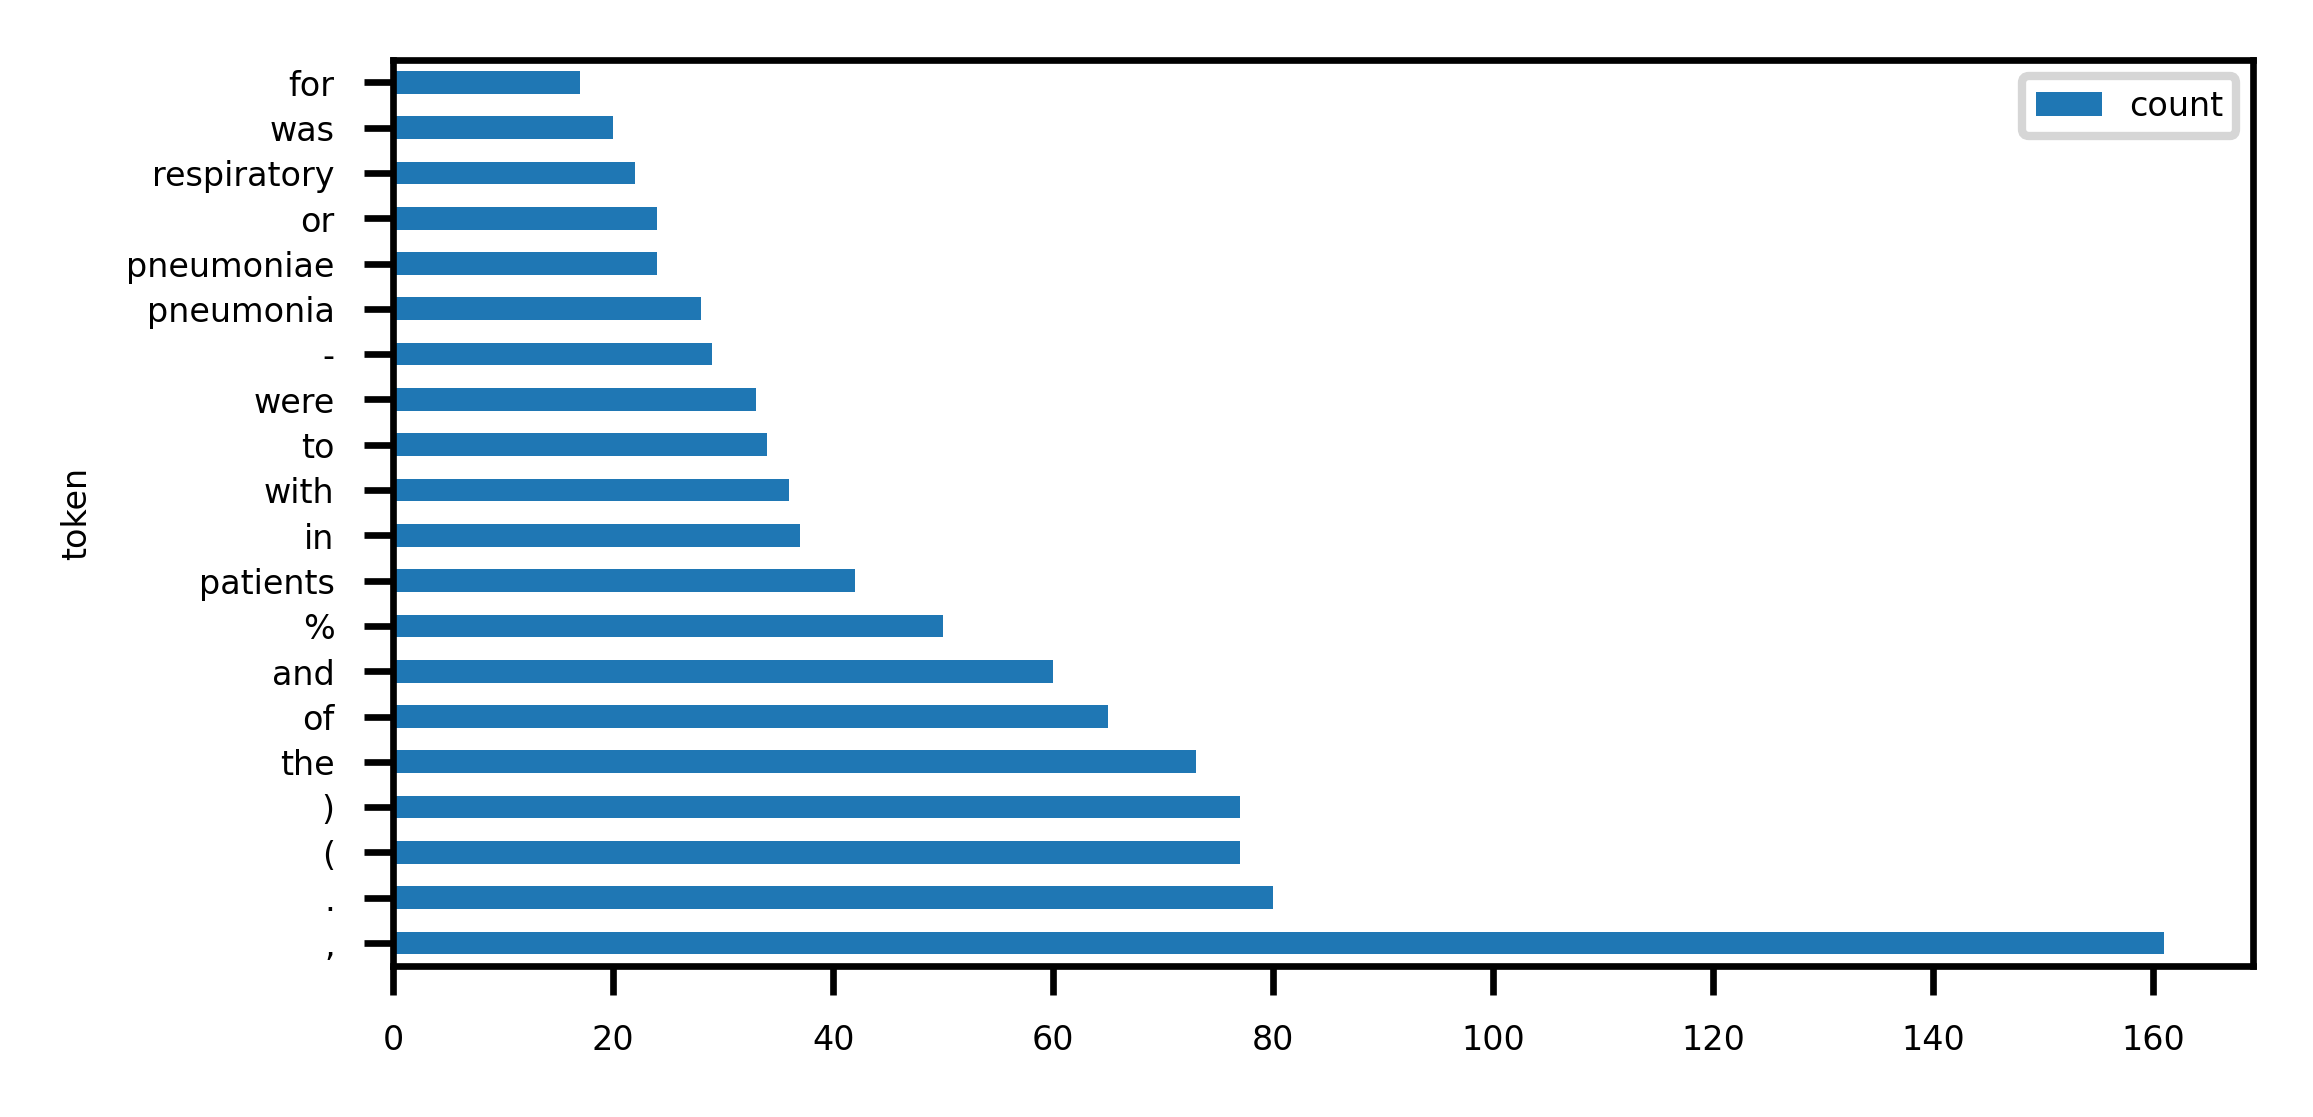

In [ ]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 4})
doc = nlp(next(doc_iter))
tokens = [token.text for token in doc]
counter = Counter(tokens)
most_common = pd.DataFrame(counter.most_common(20), columns = ['token','count'])

fig, ax = plt.subplots(1, figsize = (4,2))
most_common.plot.barh('token', 'count', ax = ax)
plt.show()

We can see above that the text was broken down into its constituent words. There are still punctuation marks left, and some spaces too. We will be addressing this in the real pipelining of processes. 

### Lemmatization

The process of *lemmatization* intends to reduce a word to its base form. This process is often related to *stemming*, but is a different beast all together. The difference between two is that lemmatization involves knowing the context of a word, while stemming does not take this into account.

The `spaCy` framework has its own english lemmatizer, which in itself is a set of rules. There are also times when we need a custom lemmatizer. This can be seamlessly done in `spaCy`.

In [ ]:
text = 'we are going to meet in a meeting tomorrow during a meet'
doc = nlp(text)
[token.lemma_ for token in doc]

['we',
 'be',
 'go',
 'to',
 'meet',
 'in',
 'a',
 'meet',
 'tomorrow',
 'during',
 'a',
 'meet']

Shown above, we can see that although the stem of *meeting* is *meet*, this was not normalized since the algorithm accounts for situations when words should not be reduce when it is a certain part of speech. Which in this case is a noun.

### Combined processing using pipeline

We now use the `pipe` API to sequentially apply the tokenizer and lemmatizer to the set of documents. We also look to remove uninformative words/characters such as stop words, punctuations, and white spaces.

We use here the `DocBin` module to serialize documents for later use.

In [ ]:
#doc_bin = spacy.tokens.DocBin(attrs = ['LEMMA', 'ENT_IOB', 'ENT_TYPE'], store_user_data = False)
token_list = []
for _doc in tqdm(nlp.pipe(doc_iter), total = len(file_list)):
    words = []
    for token in _doc:
        if not token.is_stop | token.is_space | token.is_punct:
            # we use the lemmatized word for downstream processes
            words.append(token.lemma_)
    token_list.append(words)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from collections import Counter
token_list_unnest = [word for _list in token_list for word in list(set(_list))]
word_doc_counts = Counter(token_list_unnest)

In [ ]:
pickle.dump(counts, open('/content/drive/MyDrive/num_token_counts.pkl', 'wb'))

### Creating a Text Corpus

A text corpus are a set of structured documents/texts that will be used for further statistical analysis or hypothesis testing. To create this efficiently, we use the `textacy.Corpus` class. From there on, we will be using it for further downstream processes. 

In [8]:
num_token_counts = pickle.load(open('/content/drive/MyDrive/num_token_counts.pkl', 'rb'))

get the tf-idf

Remove very rare words, we can get the sensitivity of this action afterwards. We also add indices to signify word.

In [ ]:
len(num_token_counts)

2202598

In [11]:
num_token_counts_flt = {k: (i, v) for i, (k, v) in enumerate(num_token_counts.items()) if v > 10} 
len(num_token_counts_flt)

238435

In [22]:
def calculate_tf_idf(count_dict, num_token_counts, num_docs):
  """
    Aside from the idf, this will also get the corresponding
    index of the term
  """
  idxs = []
  doc_cnt = []
  freq = []
  for k, v in count_dict.items():
    try:
      idx, cnt = num_token_counts[k]
      idxs.append(idx)
      doc_cnt.append(cnt)
      freq.append(v)
    except:
      pass
  freq = np.array(freq)
  doc_cnt = np.array(doc_cnt)
  
  # calculate l2 norm and term frequency
  l2 =  np.linalg.norm(freq)
  tf = freq/l2 

  # calculate idf-smoothed
  idf = np.log(num_docs/(1 + doc_cnt)) + 1 

  # calculate tf_idf
  tf_idf = tf * idf

  # concatenate index and tf_idf

  return np.array(idxs), tf_idf 


take it for a spin :D

In [23]:
max_len = 10 
vectorized = []
for i , _doc in enumerate(nlp.pipe(doc_iter)):
  if i > max_len:
    break
  words = []
  for token in _doc:
      if not token.is_stop | token.is_space | token.is_punct:
          # we use the lemmatized word for downstream processes
          words.append(token.lemma_)
  cnts = Counter(words)
  vector = calculate_tf_idf(cnts, num_token_counts_flt, len(file_list))
  vectorized.append(vector)
idxs, tf_idf = vectorized[0]


In [26]:
print(len(idxs), len(tf_idf))

626 626


We now create a tf record dataset to serialize examples for minibatch processing later on. 

In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.train import Example, Int64List, FloatList, Features, Feature
from tensorflow.io import TFRecordWriter

filename = 'tf_idf_vectors.tfrecord'  
def _int64_feature(value):
        return Feature(int64_list=Int64List(value=value))

def _float_feature(value):
        return Feature(float_list=FloatList(value=value))
writer = TFRecordWriter(filename)
for i , _doc in tqdm(enumerate(nlp.pipe(doc_iter)), total = len(file_list)):
  words = []
  for token in _doc:
      if not token.is_stop | token.is_space | token.is_punct:
          # we use the lemmatized word for downstream processes
          words.append(token.lemma_)
  cnts = Counter(words)
  idxs, tf_idf = calculate_tf_idf(cnts, num_token_counts_flt, len(file_list))
  feature = {
      'index0': _int64_feature(np.zeros_like(idxs)),
      'index1': _int64_feature(idxs),
      'values': _float_feature(tf_idf) 
  }
  
  example = tf.train.Example(
      features=tf.train.Features(feature=feature))
  
  # Serialize to string and write on the file
  writer.write(example.SerializeToString())
      
writer.close()

In [49]:
!mv tf_idf_vectors.tfrecord /content/drive/MyDrive/

In [47]:
my_example_features = {'sparse': tf.io.SparseFeature(index_key=['index0', 'index1'],
                                                  value_key='values',
                                                  dtype=tf.float32,
                                                  size=[1, len(num_token_counts_flt)])}
serialize = example.SerializeToString()
parsed = tf.io.parse_single_example(serialize, features = my_example_features)

In [ ]:
print(parsed['sparse'])

### Vectorization 

Now that we have a corpus, and within it are a set of tokens for each doument, we can now represent it numerically. There are a couple of ways that we can do this. 

We can one-hot encode each token which means that we flag `1` for words that are in the documents, or zero otherwise. The total length of the vector will be the total unique tokens or the lenth of the **vocabulary** of a corpus. Another way to represent these tokens is to get the frequency and use that as numerical representation of the token.

#### term-frequency-inverse document frequency (tf-idf)

Usually, it is not enough for us to know the frequency of the term to determin the importance of a certain token in a document. 

In [ ]:
import textacy.vsm
vectorizer = textacy.vsm.Vectorizer(
tf_type = 'linear', apply_idf = True, idf_type = 'smooth', 
norm = 'l2', min_df=2, max_df=0.95)

In [ ]:
dtm = vectorizer.fit_transform(
    (doc._.to_terms_list(ngrams = 1, entities = True, as_strings = True) for doc in corpus)
)
print(repr(dtm))